In [243]:
import numpy as np
import matplotlib.pyplot as plt
import math

# Paramètres

In [244]:
# Valeurs physiques
gamma = 72e-3; # Tension superficielle eau-air (en N/m)
theta_hydrophobe = 106; # Angle de contact eau-PDMS (en degrés) pré-plasmatisation https://pmc.ncbi.nlm.nih.gov/articles/PMC2967237/ 
theta_hydrophile = 30; # Angle de contact eau-PDMS (en degrés) post-plasmatisation https://pmc.ncbi.nlm.nih.gov/articles/PMC2967237/ 
rho = 1e3; # Masse volumique de l'eau (en kg/m^3)
eta = 1e-3; # Viscosité dynamique de l'eau (en Pa.s)
g = 9.81; # Accélération gravitationnelle (en m/s^2)

# Dimensions géométriques 
h_puce = 2.75e-3; # Épaisseur de la puce (en m)

d_inlet = 2.9e-3; # Diamètre interne de l'inlet (en m)
d_raman = 2e-3; # Diamètre interne du trou Raman (en m)
d_outlet = 1.5e-3 # Diamètre interne de l'outlet (en m)
d_bille = 350e-6; # Diamètre des billes (en m)

L_puits = 700e-6 # Longueur du puits (en m)
W_puits = 700e-6 # Largeur du puits (en m)
h_puits = 630e-6 # Hauteur du puits (en m)

W_canal = 700e-6 # Largeur du canal (en m)
h_canal = 700e-6 # Hauteur du canal (en m)

dist_x = 2e-3 # Longueur en x du serpentin (en m)
dist_y = 6e-3 # Longueur en y du serpentin (en m)

# Volume du système

In [245]:
# Calculs associés
dist_inout = 2* dist_x + 2.5*dist_y + (2*np.pi*W_canal)
dist_puits = dist_x + dist_y + 0.5*(2*np.pi*W_canal)
dist_tot = 2*(dist_inout + dist_puits)
print(f"\nDistance entrée-puits et sortie-puits (L1 et L4): {dist_inout*1000:.2f} mm")
print(f"Distance entre puits (L2 et L3): {dist_puits*1000:.2f} mm")
print(f"Longueur totale du canal : {dist_tot*1000:.2f} mm")

r_inlet = d_inlet / 2
r_raman = d_raman / 2
r_outlet = d_outlet / 2

A_inlet = np.pi * r_inlet**2
A_raman = np.pi * r_raman**2
A_outlet = np.pi * r_outlet**2

# Caclul du volume total
V_puits = L_puits * W_puits * h_puits
V_raman = A_raman * h_puce
V_inlet = A_inlet * h_canal
V_outlet = A_outlet * (h_canal + h_puce)

V_canal = W_canal * h_canal * (dist_tot - r_inlet - r_outlet)

V_tot = 3 * V_puits + V_inlet + V_outlet + V_canal + 3 * V_raman
print(f"\nVolume total : {V_tot*1e9:.2f} uL")

L1 = dist_inout;
L2 = dist_puits;
L3 = dist_puits;
L4 = dist_inout;
Vmax = 8.64e-9


Distance entrée-puits et sortie-puits (L1 et L4): 23.40 mm
Distance entre puits (L2 et L3): 10.20 mm
Longueur totale du canal : 67.19 mm

Volume total : 69.41 uL


# V_max selon l'analogie électrique

In [246]:
def calc_R_rect(L, w, h, eta):
    R_rect = (12 * eta * L) / (h**3 * w)
    somme = 1
    for n_i in range(1, 10, 2):
        terme_somme = (192 * h) / (np.pi**5 * n_i**5 * w) * np.tanh(n_i * np.pi * w / (2 * h))
        somme -= terme_somme
    return R_rect / somme

def volume_condensateur(D,e,theta):
    theta_rad = np.deg2rad(theta)
    return np.pi*D**2/4*e + np.pi/3*(1-np.cos(theta_rad))**2*(2+np.cos(theta_rad))*(D/(2*np.sin(theta_rad)))**3

def compute_volumes(L1, L2, L4, V0, t_final=10.0):
    """Renvoie les volumes écoulés dans chaque trou Raman pour un volume injecté V0."""

    V_inlet = volume_condensateur(d_inlet, h_puce, theta_hydrophobe)
    V_raman = volume_condensateur(d_raman, h_puce, theta_hydrophobe)
    V_outlet = volume_condensateur(d_outlet, h_puce, theta_hydrophobe)

    delta_p_inlet = np.abs(rho * g * h_puce + 2 * gamma * np.cos(np.deg2rad(theta_hydrophile)) / (d_inlet / 2))
    delta_p_raman = np.abs(rho * g * h_puce + 2 * gamma * np.cos(np.deg2rad(theta_hydrophile)) / (d_raman / 2))
    delta_p_outlet = np.abs(rho * g * h_puce + 2 * gamma * np.cos(np.deg2rad(theta_hydrophile)) / (d_outlet / 2))

    C0 = V_inlet / delta_p_inlet
    C1 = C2 = C3 = V_raman / delta_p_raman
    C4 = V_outlet / delta_p_outlet

    R1 = calc_R_rect(L1, W_canal, h_canal, eta)
    R2 = calc_R_rect(L2, W_canal, h_canal, eta)
    R3 = R2
    R4 = calc_R_rect(L4, W_canal, h_canal, eta)

    M = -np.diag([-C0, C1, C2, C3, C4])
    g1, g2, g3, g4 = 1/R1, 1/R2, 1/R3, 1/R4

    R_mat = np.array([
        [ g1,       -g1,        0.0,         0.0,     0.0],
        [ g1,  -g1 - g2,       g2,          0.0,      0.0],
        [ 0.0,       g2,    -2.0*g2,       g2,        0.0],
        [ 0.0,       0.0,       g3,   -g3 - g4,        g4],
        [0.0,        0.0,       0.0,      g4,          -g4]
    ])

    A_mat = np.linalg.inv(M) @ R_mat

    v0 = np.array([V0 / C0, 0, 0, 0, 0])
    nt = 1500
    t = np.linspace(0, t_final, nt)

    eigvals, S = np.linalg.eig(A_mat)
    S_inv = np.linalg.inv(S)
    V_t = np.zeros((nt, 5))
    for k, ti in enumerate(t):
        D = np.diag(np.exp(-eigvals * ti))
        V_t[k, :] = (S @ D @ S_inv @ v0).real

    I_t = (R_mat @ V_t.T).T
    i1, i5, i6 = I_t[:, 1], I_t[:, 2], I_t[:, 3]

    V1 = np.trapezoid(i1, t)
    V5 = np.trapezoid(i5, t)
    V6 = np.trapezoid(i6, t)
    return V1, V5, V6, t, i1, i5, i6



--- PARAMÈTRES ---
L1=23.40 mm, L2=10.20 mm, L4=23.40 mm
Vmax autorisé par trou = 8.640 µL

Coefficients k_i (V_i = k_i * V0) :
Trou 1 : k1=0.152,  Trou 2 : k5=0.152,  Trou 3 : k6=0.152

=> Volume injecté maximal V0_max = 56.865 µL

--- VOLUMES ÉCOULÉS POUR V0_max ---
Trou Raman 1 : 8.6400 µL
Trou Raman 2 : 8.6318 µL
Trou Raman 3 : 8.6350 µL


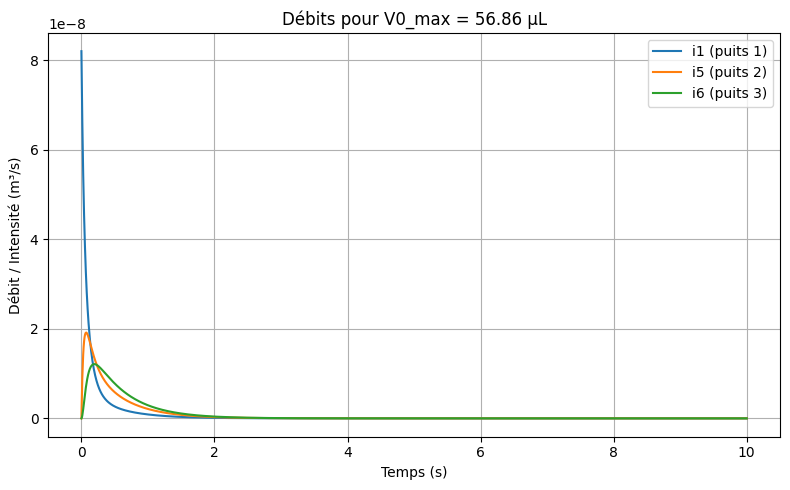

In [247]:
# Calcul du coefficient de proportionnalité
V_test = 100e-9  # 1 µL
V1_test, V5_test, V6_test, t, i1, i5, i6 = compute_volumes(L1, L2, L4, V_test)

# Chaque volume écoulé est proportionnel à V0 → V_i = k_i * V0
k1, k5, k6 = V1_test / V_test, V5_test / V_test, V6_test / V_test
V0_max = min(Vmax / k1, Vmax / k5, Vmax / k6)

# Résultats et tracé
print("\n--- PARAMÈTRES ---")
print(f"L1={L1*1e3:.2f} mm, L2={L2*1e3:.2f} mm, L4={L4*1e3:.2f} mm")
print(f"Vmax autorisé par trou = {Vmax*1e9:.3f} µL")
print(f"\nCoefficients k_i (V_i = k_i * V0) :")
print(f"Trou 1 : k1={k1:.3f},  Trou 2 : k5={k5:.3f},  Trou 3 : k6={k6:.3f}")
print(f"\n=> Volume injecté maximal V0_max = {V0_max*1e9:.3f} µL")

# Vérification : recalcul avec V0_max
V1, V5, V6, t, i1, i5, i6 = compute_volumes(L1, L2, L4, V0_max)

print("\n--- VOLUMES ÉCOULÉS POUR V0_max ---")
print(f"Trou Raman 1 : {V1*1e9:.4f} µL")
print(f"Trou Raman 2 : {V5*1e9:.4f} µL")
print(f"Trou Raman 3 : {V6*1e9:.4f} µL")

# Tracé des débits
plt.figure(figsize=(8,5));
plt.plot(t, i1, label="i1 (puits 1)");
plt.plot(t, i5, label="i5 (puits 2)");
plt.plot(t, i6, label="i6 (puits 3)");
plt.xlabel("Temps (s)");
plt.ylabel("Débit / Intensité (m³/s)");
plt.title(f"Débits pour V0_max = {V0_max*1e9:.2f} µL");
plt.legend();
plt.grid(True);
plt.tight_layout();
plt.show();

In [248]:
# Pourcentage du volume remplacé pour chaque manipulation de changement de milieu
pourcentage_remplaced_lift = [10]
for manip in range(3):
    equilibre_post_manip = (100*V0_max + pourcentage_remplaced_lift[manip]*(V_tot-V0_max))/V_tot
    pourcentage_remplaced_lift.append(equilibre_post_manip)
print(f"Pourcentage du volume remplacé = {pourcentage_remplaced_lift[3]:.2f}%")
print(f"Évolution du changement de milieu : {pourcentage_remplaced_lift}")
if pourcentage_remplaced_lift[3] > 95.5:
    print("Changement de milieu réussi")
else:
    print("Changement de milieu inadéquat")

Pourcentage du volume remplacé = 99.47%
Évolution du changement de milieu : [10, np.float64(83.73092083895376), np.float64(97.05907848057345), np.float64(99.46837683326694)]
Changement de milieu réussi


# V_max selon le débit de lift (Q_lift)

In [249]:
rho_tissus = 1020 # Densité des tissus (kg/m^3) SOURCE À CONFIRMER
rho_milieu = 1000 # Densité du milieu (kg/m^3)

In [250]:
def Q_lift(rho_tissus, rho_milieu, w_puits, d_bille):
    """ Basé sur l'équation (3-13) du mémoire de Nassim """
    current_q_lift = np.sqrt(d_bille)*w_puits**2 * np.sqrt(4/3*9.81*(rho_tissus/rho_milieu - 1));
    return current_q_lift

In [251]:
# Calcul de Q_lift
q_lift = Q_lift(rho_tissus, rho_milieu, L_puits, d_bille);
print(f"\nQ_lift = {q_lift*10**9} uL/s")

# Calcul des pressions sous le premier accès Raman et la résistance hydraulique du premier canal
P1 = 4*gamma*np.cos(np.deg2rad(theta_hydrophile))/d_raman + h_puce*rho*g;
R1 = 12*eta*L1/(h_canal**3*W_canal*(1-0.63*h_canal/W_canal))
print(f"Résistance R1 (en Pa.s/m^3)= {R1:2.6f} " )
Pmax = R1*q_lift + P1;
print(f"Pmax = {Pmax:.6f} Pa")

# Calcul du volume critique
V_critique_lift = np.pi/4*d_inlet**2 * Pmax/(rho*g);
print(f"V_max = {V_critique_lift*10**9:.6f} uL")

h_max_lift = V_critique_lift/(np.pi*d_inlet**2)*4 * 1e3;
print(f"Hauteur critique de remplissage = {h_max_lift:.6f} mm")


Q_lift = 4.688662495851031 uL/s
Résistance R1 (en Pa.s/m^3)= 3160606015.289896 
Pmax = 166.504173 Pa
V_max = 112.109391 uL
Hauteur critique de remplissage = 16.972902 mm


In [252]:
# Pourcentage du volume remplacé pour chaque manipulation de changement de milieu
pourcentage_remplaced_lift = [10]
for manip in range(3):
    equilibre_post_manip = (100*V_critique_lift + pourcentage_remplaced_lift[manip]*(V_tot-V_critique_lift))/V_tot
    pourcentage_remplaced_lift.append(equilibre_post_manip)
print(f"Pourcentage du volume remplacé = {pourcentage_remplaced_lift[3]:.2f}%")
print(f"Évolution du changement de milieu : {pourcentage_remplaced_lift}")
if pourcentage_remplaced_lift[3] > 95.5:
    print("Changement de milieu réussi")
else:
    print("Changement de milieu inadéquat")

Pourcentage du volume remplacé = 120.95%
Évolution du changement de milieu : [10, np.float64(155.3618314037073), np.float64(65.94519581808322), np.float64(120.94818141783938)]
Changement de milieu réussi


# Calculs reliés au changement de milieu

In [253]:
c_0 = 11 # Concentration initiale en mol/m^3 (Valeur typique tirée du mémoire de Nassim)
rho = 2.8e14 # Densité cellulaire (cell/m^3) (Valeur typique tirée du typique de Nassim)

D_gluc = 6.7e-10 # Diffusivité typique du glucose dans l'eau (m^2/s) https://pubmed.ncbi.nlm.nih.gov/23224430/
q_gluc = 3.9e-17 # Consommation de glucose par cellule (mol/cell*s) (Valeur typique tirée du mémoire de Nassim)

In [254]:
def calcul_Da(diametre, diffusivite, taux_consommation, densite_cellules, concentration):
    tau_diff = (diametre/2)**2 / diffusivite
    tau_reac = concentration / (taux_consommation * densite_cellules)
    return tau_diff / tau_reac

# Calcul du nombre de Damköhler
Da = calcul_Da(d_bille, D_gluc, q_gluc, rho, c_0)
print(f"\nNombre de Damköhler : Da = {Da:.2f}")
print(f"La réaction est donc beaucoup plus {'rapide' if Da > 1 else 'lente'} que la diffusion.")
print(f"C'est donc la {'diffusion' if Da < 1 else 'réaction'} qui limite l'apport en glucose aux cellules.")
print(f"Ainsi, on peut considérer que le profil de concentration de glucose est {'quasi-statique' if Da < 1 else 'variable'}.")


Nombre de Damköhler : Da = 0.05
La réaction est donc beaucoup plus lente que la diffusion.
C'est donc la diffusion qui limite l'apport en glucose aux cellules.
Ainsi, on peut considérer que le profil de concentration de glucose est quasi-statique.


In [255]:
V_M = V_puits + V_canal # Volume du milieu disponible (canal + puits)
V_T = 3* 4/3 * np.pi * (d_bille/2)**3 # Volume des tissus (les 3 billes)

# Estimation du temps avant épuisement du glucose 
# Basé sur l'équation (6) du mémoire de Nassim
t = c_0 / (q_gluc * rho) * (V_M / V_T)
print(f"\nTemps avant épuisement du glucose : {t/3600:.2f} heures")


Temps avant épuisement du glucose : 133.60 heures


# Calcul du niveau d'hypoxie

Puisque l'oxygène diffuse davantage dans le PDMS que dans l'eau, pour modéliser le pire scénario, on considère une bille entourée d'un milieu infini d'eau, tel qu'illustré ci-dessous :

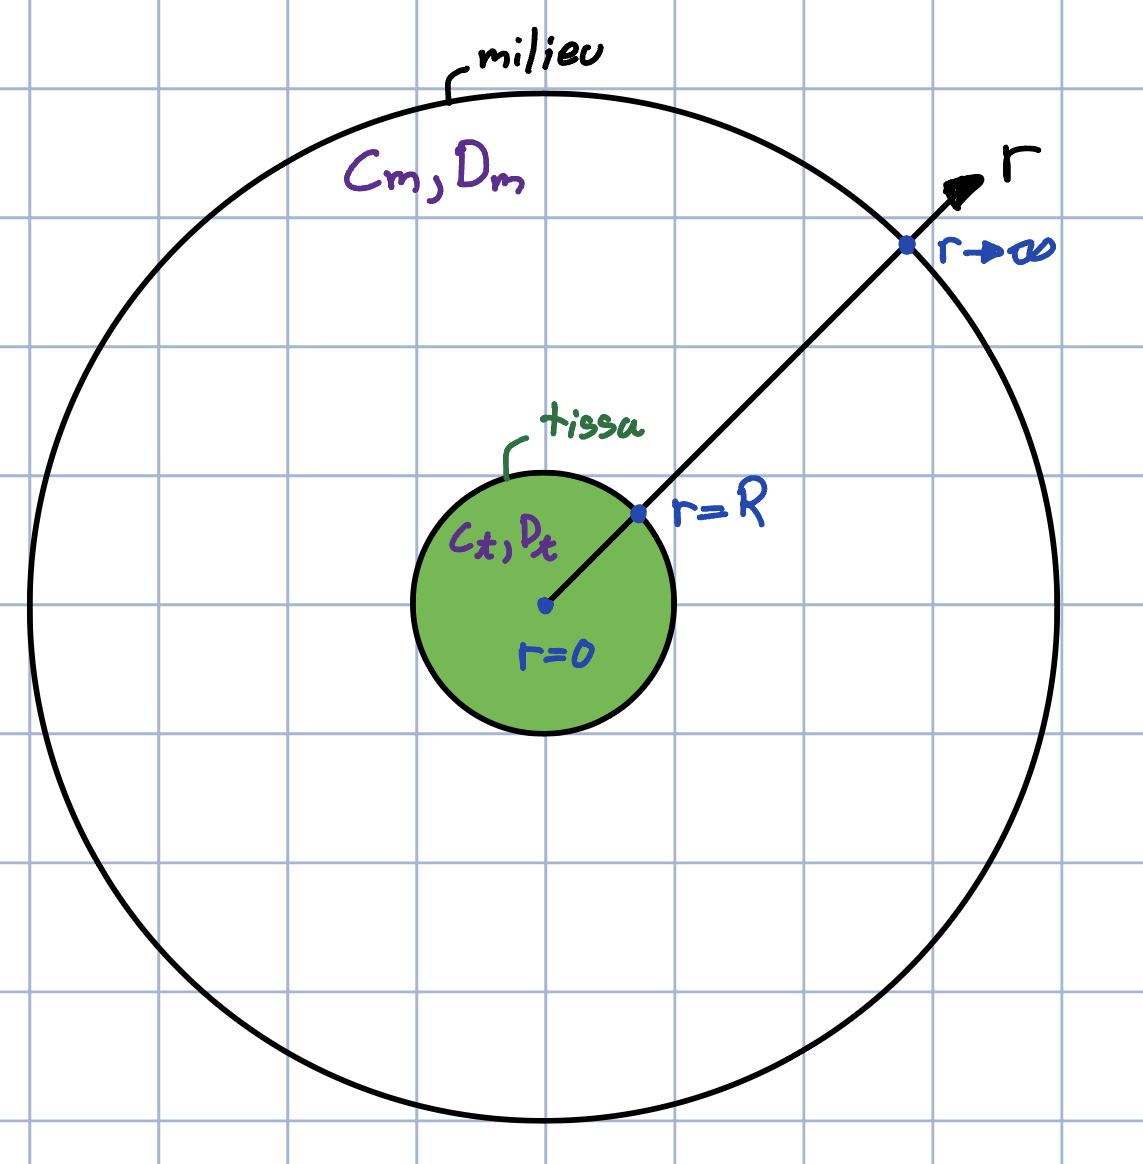

Les numéros encerclés correspondent aux conditions aux frontières :

1 - La concentration au centre du tissu est constante (Condition de Neumann) :
$$ C_t'(r=0)=0 $$

2 - La concentration à la surface ($ C_s $) est la même dans le tissu et le milieu (Conditions de Dirichlet) :
$$ C_t(r=R)=C_m(r=R)=C_s $$
(L'équation de continuité est la suivante)
$$ -D_m \frac{\partial C_m}{\partial r}|_{r=R} = -D_t \frac{\partial C_t}{\partial r}|_{r=R} $$

3 - La concentration à l'infini ($ C_{\infty} $) est définie par une condition de Dirichlet :
$$ C_t(r \rightarrow \infty)=C_{\infty} $$

Voici les valeurs considérées pour ce problème :

In [256]:
c_m = c_inf = 0.21 # Concentration d'oxygène dans le milieu (mol/m^3) (Valeur typique tirée du mémoire de Nassim)
c_t = 1.02 # Concentration d'oxygène dans le tissu (mol/m^3) (Valeur typique tirée du mémoire de Nassim)
c_hypoxie = 0.0126 # Concentration d'oxygène critique où le tissu devient hypoxique (mol/m^3) (Valeur tirée de la thèse à Elena)

D_m = 2.44e-9 # Diffusivité de l'oxygène dans le milieu (m^2/s) (Valeur typique tirée du mémoire de Nassim)
D_t = 1.85e-9 # Diffusivité de l'oxygène dans le tissu (m^2/s) (Valeur typique tirée du mémoire de Nassim)

q_O2 = 7.4e-17 # Consommation d'oxygène par cellule (mol/cell*s) (Valeur typique tirée du mémoire de Nassim)

R = d_bille/2 # Rayon de la sphère de cellules cancéreuses (m)

Partons de l'équation de convection/diffusion/réaction :

$$ \frac{\partial C}{\partial t} = D \nabla^2 C - \vec{v} \cdot \nabla C + \mathcal{R} $$

Étant donné qu'il n'y a pas de convection dans le milieu (qui est immobile), le nombre de Péclet est nul ($Pe=0$) :

$$ \frac{\partial C}{\partial t} = D \nabla^2 C + \mathcal{R} $$

Maintenant, déterminons si c'est la diffusion où la réaction qui est dominante dans cette situation. Pour cela, calculons de nombre de Damkölher:

In [257]:
Da_tissu = calcul_Da(d_bille, D_t, q_O2, rho, c_t)


print(f"\nNombre de Damköhler du tissu: Da = {Da_tissu:.2f}")
print(f"La réaction est donc beaucoup plus {'rapide' if Da_tissu > 1 else 'lente'} que la diffusion.")
print(f"C'est donc la {'diffusion' if Da_tissu < 1 else 'réaction'} qui limite l'apport en glucose aux cellules.")


Nombre de Damköhler du tissu: Da = 0.34
La réaction est donc beaucoup plus lente que la diffusion.
C'est donc la diffusion qui limite l'apport en glucose aux cellules.


On peut donc considérer que le terme de réaction ($\mathcal{R}$) dans le tissu est une constante correspondant au taux de consommation des cellules, alors que dans le milieu, il n'y a pas de réaction :

$$ \mathcal{R_t} = - \rho q $$
$$ \mathcal{R_m} = 0 $$

Combiné au fait que le système peut être considéré en une seul dimension (radiale), on obtient les équtions suivantes :

$$
\frac{\partial C_t}{\partial t} = D \left( \frac{1}{r^2} \frac{\partial}{\partial r} \left( r^2 \frac{\partial C_t}{\partial r} \right) \right) - \rho q
$$

$$
\frac{\partial C_m}{\partial t} = D \left( \frac{1}{r^2} \frac{\partial}{\partial r} \left( r^2 \frac{\partial C_m}{\partial r} \right) \right)
$$

Puisque le PDMS est très perméable à l'oxygène, on peut considérer que le volume du milieu de culutre est infini, donc que le système est en régime permanent ($\frac{\partial C_t}{\partial t} = \frac{\partial C_m}{\partial t} = 0 $) :

$$
\frac{\partial}{\partial r} \left( r^2 \frac{\partial C_t}{\partial r} \right) = \frac{\rho q r^2}{D_t}
$$

$$
\frac{\partial}{\partial r} \left( r^2 \frac{\partial C_m}{\partial r} \right) = 0
$$

En intégrant à deux reprises selon r :

$$
C_t(r)=\frac{\rho q r^2}{6D_t} - \frac{A_t}{r} + B_t
$$

$$
C_m(r) = - \frac{A_m}{r} + B_m
$$

Où $A_i$ et $B_i$ sont des constantes d'intégration. En considérant les conditions aux frontières énoncées plus haut:

$$
C_t(r)=C_s + \frac{\rho q}{6D_t} \left( r^2 - R^2 \right)
$$

$$
C_m(r) = C_{\infty} - \left( C_{\infty} - C_s \right) \frac{R}{r}
$$

En considérant l'équation de continuité, on obtient le profil de concentration au sein du tissu :

$$
C_t(r)= C_{\infty} + \frac{\rho q}{3} \left( \frac{r^2}{2D_t} - \left( \frac{1}{D_m} + \frac{1}{2D_t} \right) R^2 \right)
$$

In [258]:
# Équation de la concentration en oxygène dans le tissu en fonction du rayon
def get_tissue_02_concentration(rayon):
    return c_inf + q_O2 * rho / 3 * (rayon**2 / (2 * D_t) - (1/D_m + 1/(2*D_t)) * R**2)

Il est alors possible de vérifier si le tissu est en hypoxie. Si la concentration en oxygène au centre du sphéroïde (le minimum global) est supérieure à la concentration où les cellules sont en hypoxie, alors le sphéroïde n'est pas en hypoxie :

In [259]:
c_centre = get_tissue_02_concentration(0)
print(f"Concentration en O2 au centre du sphéroïde : {c_centre:.5f} mM")

if c_centre > c_hypoxie :
    print(f"Il n'y a pas d'hypoxie! Le taux d'hypoxie est donc de 0%.")
else :
    # Le taux d'hypoxie pourrait être calculé à partir du rayon où le seuil critique est atteint, puis calculer
    # Le pourcentage du volume en hypoxie par rapport au volume total du spéhoïde
    pass

Concentration en O2 au centre du sphéroïde : 0.06615 mM
Il n'y a pas d'hypoxie! Le taux d'hypoxie est donc de 0%.
